# A new ml learning model predicting the RMSD value

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pathlib import Path
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import sklearn.tree
import sklearn
import pickle
import re
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, auc
from sklearn.model_selection import cross_val_score

In [2]:
#Paths
AF_prediction_path = Path("../ressources/AF2").resolve()
AF_prediction_results = Path("../ressources/AF2/AF_prediction_randomized_DMI_results.xlsx").resolve()
AF_prediction_metrics = Path("../ressources/AF2/AF_metrics_all_structures.tsv").resolve()
AF_DMI_structures_folders = [Path("../ressources/AF2/AF_DMI_structures").resolve() / p for p in ['AF_DMI_structures1', 'AF_DMI_structures2', 'AF_DMI_structures3', "AF_DMI_mutated_structures"]]
AF_DDI_structures_path = Path("../ressources/AF2/AF_DDI_structures").resolve()
solved_DMI_structures_path = Path("../ressources/solved/DMI_solved_structures_hydrogens").resolve()
solved_DDI_structures_path = Path("../ressources/solved/DDI_solved_structures_hydrogens").resolve()

for p in [AF_prediction_results, AF_prediction_metrics, AF_DDI_structures_path, solved_DMI_structures_path, solved_DDI_structures_path] + AF_DMI_structures_folders:
    if not p.exists():
        print(f"{p} does not point to a valid path")

In [3]:
# Loading Data
dataAF = pd.read_csv(AF_prediction_path / "af2_full_metrics.csv")
dataAF.index = dataAF["prediction_name"] + "_" + dataAF["model_id"]
dataAF["min_distance"] = dataAF["min_distance"].fillna(value=20)
print(dataAF.columns)
dataAF

Index(['project_name', 'prediction_name', 'run_id', 'chainA_length',
       'chainB_length', 'model_id', 'model_confidence',
       'chainA_intf_avg_plddt', 'chainB_intf_avg_plddt', 'intf_avg_plddt',
       'pDockQ', 'iPAE', 'num_chainA_intf_res', 'num_chainB_intf_res',
       'num_res_res_contact', 'num_atom_atom_contact', 'RMSD_domain',
       'num_align_atoms_domain', 'align_score_domain', 'num_align_resi_domain',
       'RMSD_backbone_peptide', 'RMSD_all_atom_peptide', 'known_motif_plddt',
       'DockQ', 'iRMS', 'LRMS', 'Fnonnat', 'num_mutation_in_motif', 'label',
       'structure_name', 'file', 'hbonds', 'salt_bridges', 'buried_area',
       'min_distance', 'hydrophobic_interactions', 'ELM_Instance', 'PDB_ID'],
      dtype='object')


,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,label,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,ELM_Instance,PDB_ID
DEG_APCC_KENBOX_2_4GGD_ranked_0,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,1,DEG_APCC_KENBOX_2_4GGD,ranked_0.pdb,9,0,613.651,6.063,0,DEG_APCC_KENBOX_2,4GGD
DEG_APCC_KENBOX_2_4GGD_ranked_1,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_1,0.871984,95.793846,73.986000,89.736111,...,1,DEG_APCC_KENBOX_2_4GGD,ranked_1.pdb,9,0,580.310,6.083,0,DEG_APCC_KENBOX_2,4GGD
DEG_APCC_KENBOX_2_4GGD_ranked_2,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_2,0.760784,95.547501,57.906001,86.585239,...,1,DEG_APCC_KENBOX_2_4GGD,ranked_2.pdb,10,0,662.104,6.072,3,DEG_APCC_KENBOX_2,4GGD
DEG_APCC_KENBOX_2_4GGD_ranked_3,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_3,0.413662,94.646667,21.510000,76.362500,...,1,DEG_APCC_KENBOX_2_4GGD,ranked_3.pdb,2,0,398.498,5.417,0,DEG_APCC_KENBOX_2,4GGD
DEG_APCC_KENBOX_2_4GGD_ranked_4,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_4,0.359078,94.830001,19.753333,72.307001,...,1,DEG_APCC_KENBOX_2_4GGD,ranked_4.pdb,2,0,323.304,5.092,9,DEG_APCC_KENBOX_2,4GGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_0,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_0,0.298701,49.827778,73.161904,62.392307,...,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_0.pdb,7,3,1617.382,5.591,56,D1PF18773_PF00071,2X19
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_1,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_1,0.246961,54.362000,76.415000,66.390909,...,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_1.pdb,3,0,791.256,6.373,7,D1PF18773_PF00071,2X19
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_2,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_2,0.211579,52.651538,72.910908,61.937083,...,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_2.pdb,2,1,882.547,7.906,11,D1PF18773_PF00071,2X19
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_3,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_3,0.211144,50.398334,78.798751,66.627144,...,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_3.pdb,7,5,1020.896,4.628,44,D1PF18773_PF00071,2X19


### Analyzing the RMSD data

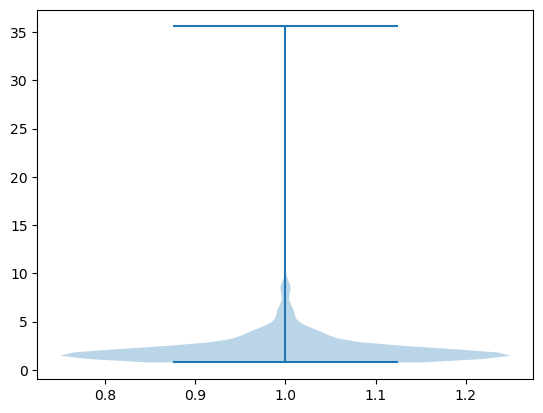

In [5]:
plt.violinplot([dataAF[dataAF["num_mutation_in_motif"] == "known minimal"]["RMSD_domain"]])
plt.show()

In [4]:
X_columns = ["model_confidence", "chainA_intf_avg_plddt", "chainB_intf_avg_plddt", "intf_avg_plddt", "pDockQ", "iPAE", 
            "buried_area", "min_distance", "hbonds", "salt_bridges", "hydrophobic_interactions",
            "num_chainA_intf_res", "num_chainB_intf_res", "num_res_res_contact", "num_atom_atom_contact", "chainA_length", "chainB_length"]
dataAF_randomDMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "random minimal")]
dataAF_mutated1DMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "1")]
dataAF_mutated2DMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "2")]
dataAF_randomDDI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "approved minimal DDI", dataAF["num_mutation_in_motif"] == "random minimal DDI")]

dataAF_randomDMI = dataAF_randomDMI[dataAF_randomDMI["model_id"] == "ranked_0"]
dataAF_mutated1DMI = dataAF_mutated1DMI[dataAF_mutated1DMI["model_id"] == "ranked_0"]
dataAF_mutated2DMI = dataAF_mutated2DMI[dataAF_mutated2DMI["model_id"] == "ranked_0"]
dataAF_randomDDI = dataAF_randomDDI[dataAF_randomDDI["model_id"] == "ranked_0"]

y_randomDMI = np.logical_and(dataAF_randomDMI["RMSD_all_atom_peptide"] <= 5, dataAF_randomDMI["RMSD_domain"] <= 5)

print(dataAF_randomDMI.shape, dataAF_mutated1DMI.shape, dataAF_mutated2DMI.shape, dataAF_randomDDI.shape)


randomDMI_xy = train_test_split(dataAF_randomDMI[X_columns], y_randomDMI , test_size=0.2, random_state=2501, shuffle=True)
mutated1DMI_xy = train_test_split(dataAF_mutated1DMI[X_columns], dataAF_mutated1DMI["label"], test_size=0.2, random_state=2501, shuffle=True)
mutated2DMI_xy = train_test_split(dataAF_mutated2DMI[X_columns], dataAF_mutated2DMI["label"], test_size=0.2, random_state=2501, shuffle=True)
randomDDI_xy = train_test_split(dataAF_randomDDI[X_columns], dataAF_randomDDI["label"], test_size=0.2, random_state=2501, shuffle=True)

print("Random DMI: Train", randomDMI_xy[0].shape, "Test", randomDMI_xy[1].shape)
print("1 Mutation DMI: Train", mutated1DMI_xy[0].shape, "Test", mutated1DMI_xy[1].shape)
print("2 Mutation DMI: Train", mutated2DMI_xy[0].shape, "Test", mutated2DMI_xy[1].shape)
print("Random DDI: Train", randomDDI_xy[0].shape, "Test", randomDDI_xy[1].shape)


(267, 38) (267, 38) (267, 38) (91, 38)
Random DMI: Train (213, 17) Test (54, 17)
1 Mutation DMI: Train (213, 17) Test (54, 17)
2 Mutation DMI: Train (213, 17) Test (54, 17)
Random DDI: Train (72, 17) Test (19, 17)


Random DMI: Train (66, 17) Test (67, 17)


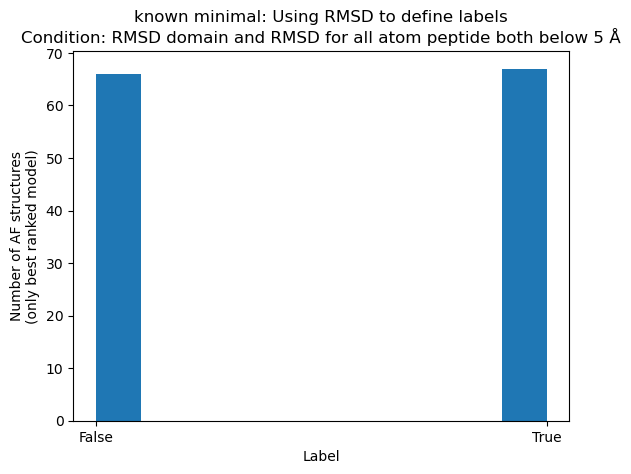

In [36]:
dataAF_known_minimal_DMI = dataAF[dataAF["num_mutation_in_motif"] == "known minimal"]
dataAF_known_minimal_DMI = dataAF_known_minimal_DMI[dataAF_known_minimal_DMI["model_id"] == "ranked_0"]
y_known_minimal_DMI = np.logical_and(dataAF_known_minimal_DMI["RMSD_all_atom_peptide"] <= 5, dataAF_known_minimal_DMI["RMSD_domain"] <= 3)
known_minimal_DMI_xy = train_test_split(dataAF_known_minimal_DMI[X_columns], y_known_minimal_DMI , test_size=0.5, random_state=2501, shuffle=True)
print("Random DMI: Train", known_minimal_DMI_xy[0].shape, "Test", known_minimal_DMI_xy[1].shape)
plt.hist([int(v) for v in y_known_minimal_DMI])
plt.xticks([0,1], ["False", "True"])
plt.xlabel("Label")
plt.ylabel("Number of AF structures\n(only best ranked model)")
plt.title("known minimal: Using RMSD to define labels\nCondition: RMSD domain and RMSD for all atom peptide both below 5 Å")
plt.show()

In [59]:
y_known_minimal_DMI = np.log2(np.array(dataAF_known_minimal_DMI["RMSD_all_atom_peptide"]))
known_minimal_DMI_xy = train_test_split(dataAF_known_minimal_DMI[X_columns], y_known_minimal_DMI , test_size=0.2, random_state=2503, shuffle=True)

In [8]:
display(known_minimal_DMI_xy[2])

array([ 1.4816259 ,  0.07121291,  1.6956016 ,  2.21782949,  2.55642688,
        0.86147865,  0.91897903,  1.09650107,  4.64813131,  2.90578765,
        0.27402504,  1.74006298,  2.87617921,  1.23437131, -0.33001972,
        0.1103377 ,  3.71032541,  1.939357  ,  2.53445274,  0.34594173,
        3.09066682,  2.86032517,  3.56515462,  0.52431489,  3.05916702,
        1.7835719 ,  0.92170395,  4.03885638,  4.38437997, -0.26267631,
        0.40394963,  3.41506579,  2.85767116,  3.61711341,  1.80633692,
        3.18739738,  4.70949615,  2.29752239,  2.46286131,  1.23758708,
        0.97803544,  1.38830968,  2.82352973,  0.22864991,  4.1485627 ,
        4.78877767,  1.05069413,  2.82972003,  2.87226822,  0.13727949,
        0.97634342,  1.50284333,  5.39994218,  0.80404434,  3.77404021,
        2.09526035,  5.36926665,  0.87332498,  3.62374276,  2.60481765,
        1.11417983,  2.5032694 ,  2.41570206,  0.51002018,  0.80975861,
        0.83457444,  0.25284731,  3.03516322,  1.26673565,  2.03

In [9]:
known_minimal_DMI_xy[0]

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,hydrophobic_interactions,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length
DOC_MAPK_MEF2A_6_4H3Q_ranked_0,0.871316,95.066110,77.487501,89.657307,0.155389,3.603134,1069.718,4.957,3,1,21,18,8,35,233,352,9
LIG_FXI_DFP_1_5EOD_ranked_0,0.545994,90.554211,58.296001,83.833750,0.095677,5.475009,862.647,5.390,5,3,54,19,5,32,272,84,5
LIG_PDZ_WMINUS1_1_1ZUB_ranked_0,0.912677,96.796249,92.852499,96.007499,0.249157,1.356875,844.052,4.089,6,0,68,16,4,27,272,89,4
TRG_DILEU_BAEN_1_4NEE_ranked_0,0.835735,97.152143,87.936000,94.726842,0.226912,1.752141,780.062,4.911,1,0,37,14,5,26,179,142,6
LIG_ULM_U2AF65_1_1O0P_ranked_0,0.772792,97.338889,81.533751,92.475770,0.125401,1.932657,1157.226,4.544,16,14,59,18,8,32,391,104,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIG_TRAF2_1_1CA9_ranked_0,0.804990,96.208824,73.912499,91.961905,0.209554,3.499980,743.931,4.432,7,5,0,17,4,26,224,191,4
LIG_EVH1_3_1MKE_ranked_0,0.614904,89.875999,60.704000,80.152000,0.098467,4.810015,667.674,5.899,3,0,81,10,5,17,183,114,6
LIG_CAP-GLY_2_3RDV_ranked_0,0.474271,96.080909,68.675001,86.408236,0.086522,3.986218,595.349,4.595,4,0,7,11,6,20,161,47,7
DOC_ANK_TNKS_1_3TWU_ranked_0,0.934440,98.668890,95.318749,97.638077,0.378785,1.402573,1112.920,3.802,8,5,40,18,8,36,446,160,8


In [ ]:
dataAF_pairedDMI = dataAF[np.logical_and(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["model_id"] == "ranked_0")]
dataAF_pairedDMI = dataAF_pairedDMI[dataAF_pairedDMI["RMSD_all_atom_peptide"] < 20]
pariedDMI_xy = train_test_split(dataAF_pairedDMI[X_columns], dataAF_pairedDMI["RMSD_all_atom_peptide"], test_size=0.2, random_state=2501, shuffle=True)
print("Train", pariedDMI_xy[0].shape, "Test", pariedDMI_xy[1].shape)

Train (97, 17) Test (25, 17)


In [37]:
def Fit(name, data, fitFunc, params=None, columns=None, plot=False):
    x_train, x_test, y_train, y_test = data
    if columns is not None:
        x_train, x_test = x_train[columns], x_test[columns]

    model = fitFunc(x_train, y_train, *params)
    y_predict = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    score = accuracy_score(y_test, y_predict)
    roc_score = roc_auc_score(y_test, y_prob[:,1])
    roc_score_confidence = roc_auc_score(y_test, x_test["model_confidence"])
    roc_curvexy = roc_curve(y_test, y_prob[:,1])
    roc_curvexy_confidence = roc_curve(y_test, x_test["model_confidence"])

    print("Score:", score)
    print("ROC_AUC_score:", roc_score)
    display(model)

    _line2D = plt.plot(roc_curvexy[0], roc_curvexy[1], label=f"{name} ml prediction (AUC = {roc_score:.2f})")[0]
    c = np.array(colors.to_rgb(_line2D.get_color()))
    c1 = np.clip(1.2*c, a_max=1, a_min=None)
    c2 = 0.7*c
    _line2D.set_color(c1)
    plt.plot(roc_curvexy_confidence[0], roc_curvexy_confidence[1], label=f"{name} model confidence (AUC = {roc_score_confidence:.2f})", color=c2)
    
    if plot:
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve for Model and Test Subset Features")
        plt.legend(loc="lower right")
        plt.show()
    return model

In [38]:
def FitRandomForrest(x_train, y_train, param_distributions, n_iter=10, cv=None):
    rf = RandomForestClassifier(random_state=2501, n_estimators=200)
    rs = RandomizedSearchCV(n_iter=n_iter, estimator=rf, param_distributions=param_distributions, scoring="accuracy", n_jobs=-1, verbose=2, random_state=2501, cv=cv)
    rs.fit(x_train, y_train)
    return rs.best_estimator_

In [ ]:
def LassoRegression

In [19]:
params = {
    "min_impurity_decrease" : [0, 0.05, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07],
    "max_features": ["sqrt", 4, 6, 8, 10, 12, 14],
    "max_depth": [None, 6, 8, 10, 12, 14, 16],
    "min_samples_split": [2,3,4,5,6],
    "max_leaf_nodes": [None, 10, 20, 40, 60, 80, 100]
}

In [41]:
params = {
    "min_impurity_decrease" : [0.05],
    "max_features": ["sqrt"],
    "max_depth": [6]
}

### Predicting RMSD value

c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Score: 0.7910447761194029
ROC_AUC_score: 0.8083778966131907


RandomForestClassifier(max_depth=6, min_impurity_decrease=0.05,
                       n_estimators=200, random_state=2501)

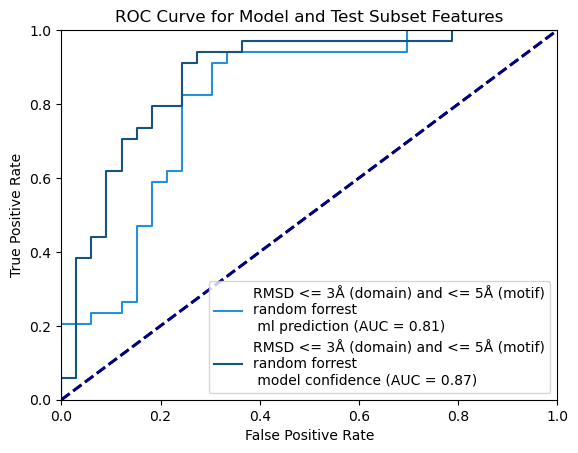

In [44]:
model = Fit("RMSD <= 3Å (domain) and <= 5Å (motif)\nrandom forrest\n", known_minimal_DMI_xy, FitRandomForrest, params=[params], plot=True)

(array([0.        , 0.        , 0.        , 0.03030303, 0.03030303,
       0.09090909, 0.09090909, 0.12121212, 0.12121212, 0.15151515,
       0.15151515, 0.24242424, 0.24242424, 0.3030303 , 0.3030303 ,
       0.33333333, 0.33333333, 0.42424242, 0.42424242, 0.45454545,
       0.45454545, 0.48484848, 0.48484848, 0.54545455, 0.54545455,
       0.72727273, 0.72727273, 1.        ]), array([0.        , 0.03030303, 0.27272727, 0.27272727, 0.3030303 ,
       0.3030303 , 0.33333333, 0.33333333, 0.36363636, 0.36363636,
       0.60606061, 0.60606061, 0.63636364, 0.63636364, 0.6969697 ,
       0.6969697 , 0.72727273, 0.72727273, 0.75757576, 0.75757576,
       0.81818182, 0.81818182, 0.90909091, 0.90909091, 0.93939394,
       0.93939394, 1.        , 1.        ]), array([       inf, 0.94713631, 0.92724053, 0.92119159, 0.9209309 ,
       0.91790978, 0.91258804, 0.90970247, 0.90744224, 0.90363379,
       0.86575922, 0.86066597, 0.86005999, 0.85144099, 0.84017959,
       0.83715697, 0.83530542, 0.82674

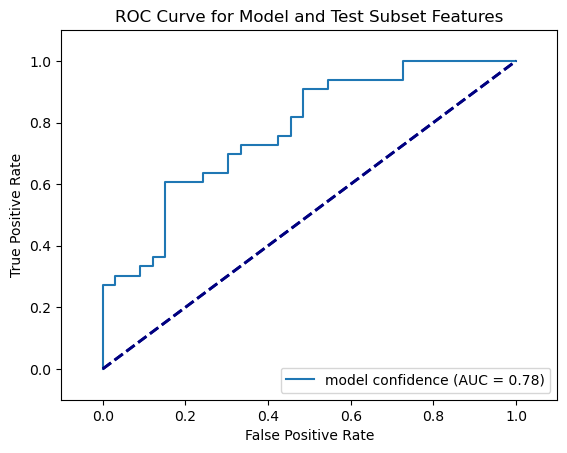

In [45]:
x_train, y_train = known_minimal_DMI_xy[0], known_minimal_DMI_xy[2]
roc_score_confidence = roc_auc_score(y_train, x_train["model_confidence"])
roc_curvexy_confidence = roc_curve(y_train, x_train["model_confidence"])
print(roc_curvexy_confidence)

plt.plot(roc_curvexy_confidence[0], roc_curvexy_confidence[1], label=f"model confidence (AUC = {roc_score_confidence:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Model and Test Subset Features")
plt.legend(loc="lower right")
plt.show()

(array([0.        , 0.        , 0.        , 0.03030303, 0.03030303,
       0.06060606, 0.06060606, 0.09090909, 0.09090909, 0.12121212,
       0.12121212, 0.15151515, 0.15151515, 0.18181818, 0.18181818,
       0.24242424, 0.24242424, 0.27272727, 0.27272727, 0.36363636,
       0.36363636, 0.78787879, 0.78787879, 1.        ]), array([0.        , 0.02941176, 0.05882353, 0.05882353, 0.38235294,
       0.38235294, 0.44117647, 0.44117647, 0.61764706, 0.61764706,
       0.70588235, 0.70588235, 0.73529412, 0.73529412, 0.79411765,
       0.79411765, 0.91176471, 0.91176471, 0.94117647, 0.94117647,
       0.97058824, 0.97058824, 1.        , 1.        ]), array([       inf, 0.9628835 , 0.95085092, 0.94869374, 0.91824407,
       0.9126775 , 0.90884689, 0.90566959, 0.87557084, 0.87488461,
       0.86822398, 0.85690488, 0.85312187, 0.85098155, 0.84529795,
       0.84134799, 0.82480615, 0.80405048, 0.79512816, 0.75761753,
       0.72762623, 0.55627409, 0.54599385, 0.21350293]))


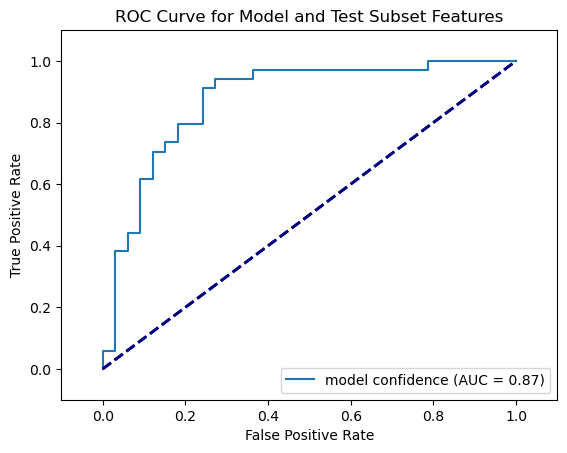

In [46]:
x_test, y_test = known_minimal_DMI_xy[1], known_minimal_DMI_xy[3]
roc_score_confidence = roc_auc_score(y_test, x_test["model_confidence"])
roc_curvexy_confidence = roc_curve(y_test, x_test["model_confidence"])
print(roc_curvexy_confidence)

plt.plot(roc_curvexy_confidence[0], roc_curvexy_confidence[1], label=f"model confidence (AUC = {roc_score_confidence:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Model and Test Subset Features")
plt.legend(loc="lower right")
plt.show()

In [ ]:
x = np.log2(np.array(dataAF_known_minimal_DMI["RMSD_all_atom_peptide"]))
y = np.log2(np.array(dataAF_known_minimal_DMI["RMSD_domain"]))
m = np.max(np.array([x, y]), axis=0)

array([ 0.89527452,  3.77404021, -0.04873201,  2.34187154,  0.13727949,
        3.03748713,  2.82352973,  2.83074004, -0.26267631,  0.75371336,
        3.38457443,  0.29102424,  1.00477476,  2.03923418,  1.37995418,
        0.81464094,  1.00425322,  2.5032694 ,  1.38830968,  1.4816259 ,
        1.80633692,  0.03343611,  1.22259933,  5.36926665,  1.0228803 ,
        4.76872164, -0.30216428,  1.65800997, -0.33001972,  2.32740695,
        3.4812078 ,  3.93607221,  0.49751833,  1.94704152,  4.38437997,
        0.34594173,  0.87332498,  2.87226822,  5.48038444,  2.68390934,
        5.39994218,  2.58664202,  0.80975861,  0.25284731,  0.40394963,
        3.41506579,  2.32835896,  3.29462369,  2.28095862,  0.80404434,
        4.96490487,  3.86975771,  4.70949615,  0.62134106,  1.0807837 ,
        2.90578765,  3.62374276,  1.01081764,  0.97634342,  2.29752239,
        2.60481765,  3.44934868,  4.78877767,  0.07121291,  0.97803544,
        5.04385084,  4.03885638,  4.64813131,  0.30779657,  2.86

array([ 0.89527452,  3.77404021, -0.04873201,  2.34187154,  0.39058673,
        3.03748713,  2.82352973,  2.83074004,  0.10665574,  0.75371336,
        3.38457443,  0.33421654,  1.00477476,  2.03923418,  1.37995418,
        0.81464094,  1.00425322,  2.5032694 ,  2.13010358,  1.4816259 ,
        1.80633692,  0.89642083,  1.22259933,  5.36926665,  1.0228803 ,
        4.76872164, -0.30122021,  1.65800997,  0.81984063,  2.32740695,
        3.4812078 ,  3.93607221,  1.17856289,  1.94704152,  4.38437997,
        0.6838875 ,  0.87332498,  2.87226822,  5.48038444,  2.68390934,
        5.39994218,  2.58664202,  1.65123338,  0.25284731,  0.40394963,
        3.41506579,  2.32835896,  3.29462369,  2.28095862,  0.80404434,
        4.96490487,  3.86975771,  4.70949615,  0.62134106,  1.0807837 ,
        2.90578765,  3.62374276,  2.28378429,  0.97634342,  2.29752239,
        2.60481765,  3.44934868,  4.78877767,  0.85740026,  1.62229406,
        5.04385084,  4.03885638,  4.64813131,  0.80280693,  2.86

array([ True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True, False,
        True, False,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True, False,  True, False,  True,
       False,  True,  True,  True,  True, False, False, False, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
        True, False,  True,  True,  True,  True, False,  True, False,
       False,  True,  True,  True,  True, False, False, False, False,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,

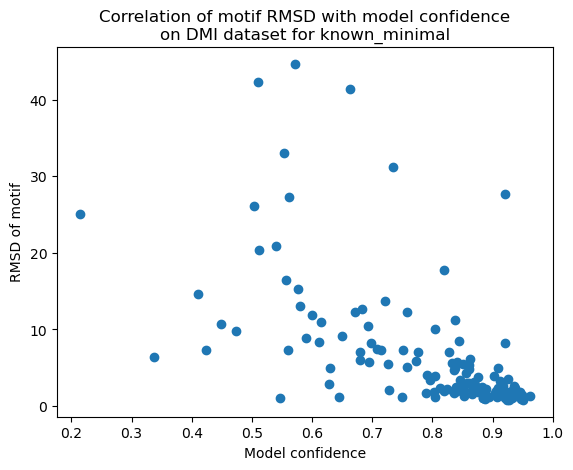

In [47]:
plt.scatter(dataAF_known_minimal_DMI["model_confidence"], dataAF_known_minimal_DMI["RMSD_all_atom_peptide"])
plt.title("Correlation of motif RMSD with model confidence\non DMI dataset for known_minimal")
plt.ylabel("RMSD of motif")
plt.xlabel("Model confidence")
plt.show()

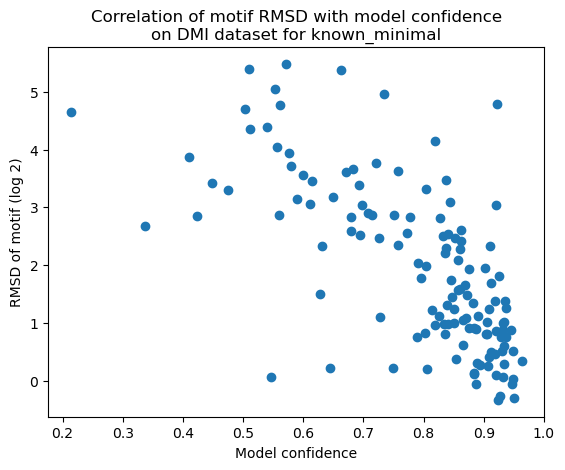

In [48]:
x = np.log2(np.array(dataAF_known_minimal_DMI["RMSD_all_atom_peptide"]))
y = np.log2(np.array(dataAF_known_minimal_DMI["RMSD_domain"]))
m = np.max(np.array([x, y]), axis=0)
plt.scatter(dataAF_known_minimal_DMI["model_confidence"], x)
plt.title("Correlation of motif RMSD with model confidence\non DMI dataset for known_minimal")
plt.ylabel("RMSD of motif (log 2)")
plt.xlabel("Model confidence")
plt.show()

In [188]:
x = dataAF_known_minimal_DMI[np.logical_and(dataAF_known_minimal_DMI["model_confidence"] < 0.6, dataAF_known_minimal_DMI["RMSD_all_atom_peptide"] < 4)]
x

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,label,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,ELM_Instance,PDB_ID
LIG_FXI_DFP_1_5EOD_ranked_0,AlphaFold_benchmark,LIG_FXI_DFP_1_5EOD,run37,84,5,ranked_0,0.545994,90.554211,58.296001,83.83375,...,1,LIG_FXI_DFP_1_5EOD,ranked_0.pdb,5,3,862.647,5.39,54,LIG_FXI_DFP_1,5EOD


In [26]:
known_minimal_DMI_xy[1]

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,hydrophobic_interactions,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length
DOC_PP2B_PXIXI_1_4F0Z_ranked_0,0.950851,97.779376,93.825715,96.576088,0.273246,1.753244,1000.354,4.648,7,0,64,16,7,32,311,292,7
LIG_AP2ALPHA_2_1KYU_ranked_0,0.336399,80.788572,28.813334,65.196000,0.020864,13.087950,415.676,6.627,0,1,61,7,3,9,104,113,4
DOC_SPAK_OSR1_1_2V3S_ranked_0,0.868224,96.943333,94.070000,96.098235,0.181340,1.421277,715.980,4.623,5,2,58,12,5,23,217,62,5
LIG_RB_LXCXE_1_1GH6_ranked_0,0.512168,86.696315,42.245385,68.638125,0.091400,7.397928,1446.210,6.370,6,2,67,19,13,37,284,123,17
LIG_CAP-GLY_1_2PZO_ranked_0,0.630446,96.279090,79.196001,90.940625,0.104709,2.486564,598.847,4.635,6,2,58,11,5,21,220,46,5
DOC_MAPK_GRA24_9_5ETA_ranked_0,0.932151,93.524615,89.811817,92.420810,0.346038,2.328821,1540.469,4.719,11,11,63,26,11,53,389,350,15
LIG_PTB_APO_2_1NTV_ranked_0,0.933797,97.217917,94.986251,96.660001,0.367257,1.446211,1368.584,4.395,8,3,60,24,8,43,493,131,8
LIG_NBOX_RRM_1_2KXH_ranked_0,0.804050,93.216153,52.914285,79.110499,0.086315,3.658036,806.732,5.680,3,2,89,13,7,25,192,196,11
LIG_PROFILIN_1_2V8C_ranked_0,0.824806,96.488890,77.238572,88.066876,0.078212,2.717569,600.568,5.954,3,0,89,9,7,19,187,135,7
DOC_MAPK_REVD_3_3TEI_ranked_0,0.948570,97.407500,92.674616,95.744595,0.380620,1.985882,1507.497,4.612,13,10,14,24,13,55,425,349,15


In [27]:
known_minimal_DMI_xy[3]

DOC_PP2B_PXIXI_1_4F0Z_ranked_0          True
LIG_AP2ALPHA_2_1KYU_ranked_0           False
DOC_SPAK_OSR1_1_2V3S_ranked_0           True
LIG_RB_LXCXE_1_1GH6_ranked_0           False
LIG_CAP-GLY_1_2PZO_ranked_0            False
DOC_MAPK_GRA24_9_5ETA_ranked_0          True
LIG_PTB_APO_2_1NTV_ranked_0             True
LIG_NBOX_RRM_1_2KXH_ranked_0           False
LIG_PROFILIN_1_2V8C_ranked_0            True
DOC_MAPK_REVD_3_3TEI_ranked_0           True
LIG_WW_1_1EG4_ranked_0                  True
LIG_EH1_1_2CE8_ranked_0                 True
LIG_TRFH_1_3BQO_ranked_0                True
TRG_ENDOCYTIC_2_1BXX_ranked_0           True
DEG_KELCH_KEAP1_2_3WN7_ranked_0        False
LIG_SH3_3_2GBQ_ranked_0                False
LIG_LYPXL_L_2_2R02_ranked_0             True
DOC_MAPK_DCC_7_2B9J_ranked_0            True
DOC_AGCK_PIF_3_1ATP_ranked_0           False
DEG_SCF_TIR1_1_2P1Q_ranked_0           False
LIG_REV1CTD_RIR_1_2LSI_ranked_0         True
LIG_ARL_BART_1_4ZI2_ranked_0           False
DEG_SPOP_S

In [35]:
known_minimal_DMI_xy[1]["model_confidence"]

DOC_PP2B_PXIXI_1_4F0Z_ranked_0         0.950851
LIG_AP2ALPHA_2_1KYU_ranked_0           0.336399
DOC_SPAK_OSR1_1_2V3S_ranked_0          0.868224
LIG_RB_LXCXE_1_1GH6_ranked_0           0.512168
LIG_CAP-GLY_1_2PZO_ranked_0            0.630446
DOC_MAPK_GRA24_9_5ETA_ranked_0         0.932151
LIG_PTB_APO_2_1NTV_ranked_0            0.933797
LIG_NBOX_RRM_1_2KXH_ranked_0           0.804050
LIG_PROFILIN_1_2V8C_ranked_0           0.824806
DOC_MAPK_REVD_3_3TEI_ranked_0          0.948570
LIG_WW_1_1EG4_ranked_0                 0.932109
LIG_EH1_1_2CE8_ranked_0                0.905670
LIG_TRFH_1_3BQO_ranked_0               0.918244
TRG_ENDOCYTIC_2_1BXX_ranked_0          0.927885
DEG_KELCH_KEAP1_2_3WN7_ranked_0        0.757618
LIG_SH3_3_2GBQ_ranked_0                0.682575
LIG_LYPXL_L_2_2R02_ranked_0            0.847448
DOC_MAPK_DCC_7_2B9J_ranked_0           0.904761
DOC_AGCK_PIF_3_1ATP_ranked_0           0.693182
DEG_SCF_TIR1_1_2P1Q_ranked_0           0.776602
LIG_REV1CTD_RIR_1_2LSI_ranked_0        0

## Trying a deep learning approach (it can't hurt)

In [60]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

x_train, x_test, y_train, y_test = known_minimal_DMI_xy

scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

#clf = MLPRegressor(solver='lbfgs', alpha=1e-2, activation="identity", hidden_layer_sizes=(20, 10, 5), random_state=1)
#clf.fit(x_train_scaled, y_train)

reg = LinearRegression().fit(x_train_scaled, y_train)
display(reg)
print("Score", reg.score(x_test_scaled, y_test))

LinearRegression()

Score 0.2823732603748723


In [67]:
from sklearn.linear_model import Lasso
reg = Lasso(alpha=0.05).fit(x_train_scaled, y_train)
reg.score(x_test_scaled, y_test)

0.24391094791163814

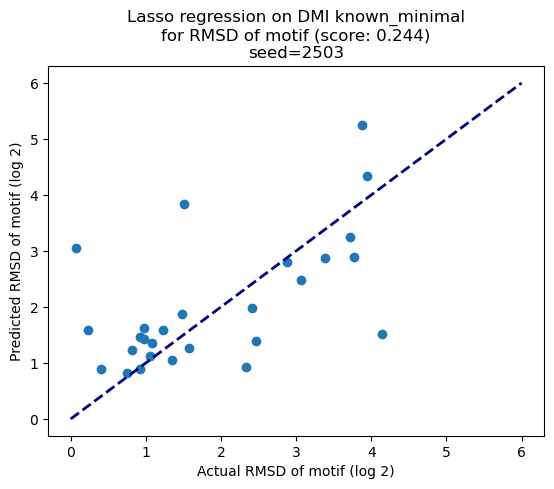

In [69]:
y_pred = reg.predict(x_test_scaled)
score = reg.score(x_test_scaled, y_test)
plt.title(f"Lasso regression on DMI known_minimal\nfor RMSD of motif (score: {round(score,3)})\nseed=2503")
plt.scatter(y_test, y_pred)
plt.xlabel("Actual RMSD of motif (log 2)")
plt.ylabel("Predicted RMSD of motif (log 2)")
plt.plot([0, 6], [0, 6], color='navy', lw=2, linestyle='--')
plt.show()

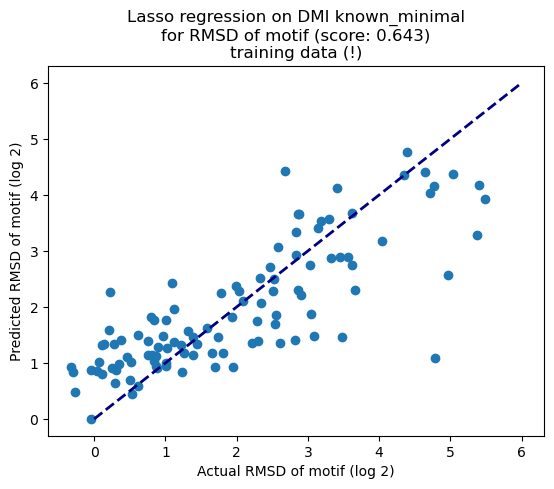

In [70]:
y_pred = reg.predict(x_train_scaled)
score = reg.score(x_train_scaled, y_train)
plt.title(f"Lasso regression on DMI known_minimal\nfor RMSD of motif (score: {round(score,3)})\ntraining data (!)")
plt.scatter(y_train, y_pred)
plt.xlabel("Actual RMSD of motif (log 2)")
plt.ylabel("Predicted RMSD of motif (log 2)")
plt.plot([0, 6], [0, 6], color='navy', lw=2, linestyle='--')
plt.show()

In [193]:
dataAF_known_minimal_DMI[np.abs(dataAF_known_minimal_DMI["model_confidence"] - 0.545994) <= 0.001]["RMSD_all_atom_peptide"]

LIG_FXI_DFP_1_5EOD_ranked_0    1.0506
Name: RMSD_all_atom_peptide, dtype: float64

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,label,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,ELM_Instance,PDB_ID
DEG_APCC_KENBOX_2_4GGD_ranked_0,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,1,DEG_APCC_KENBOX_2_4GGD,ranked_0.pdb,9,0,613.651,6.063,0,DEG_APCC_KENBOX_2,4GGD
DEG_COP1_1_5IGO_ranked_0,AlphaFold_benchmark,DEG_COP1_1_5IGO,run37,324,8,ranked_0,0.720772,92.602106,55.190001,82.529616,...,1,DEG_COP1_1_5IGO,ranked_0.pdb,6,0,1025.173,5.075,54,DEG_COP1_1,5IGO
DEG_KELCH_KEAP1_1_2FLU_ranked_0,AlphaFold_benchmark,DEG_KELCH_KEAP1_1_2FLU,run37,285,6,ranked_0,0.947136,98.717500,92.583332,97.301923,...,1,DEG_Kelch_Keap1_1_2FLU,ranked_0.pdb,12,11,853.680,5.658,6,DEG_Kelch_Keap1_1,2FLU
DEG_KELCH_KEAP1_2_3WN7_ranked_0,AlphaFold_benchmark,DEG_KELCH_KEAP1_2_3WN7,run37,286,7,ranked_0,0.757618,96.681177,55.273333,85.879130,...,1,DEG_Kelch_Keap1_2_3WN7,ranked_0.pdb,4,3,847.029,5.699,18,DEG_Kelch_Keap1_2,3WN7
DEG_MDM2_SWIB_1_1YCR_ranked_0,AlphaFold_benchmark,DEG_MDM2_SWIB_1_1YCR,run37,80,8,ranked_0,0.883411,98.155000,94.980000,97.289091,...,1,DEG_MDM2_SWIB_1_1YCR,ranked_0.pdb,2,0,969.729,4.725,104,DEG_MDM2_SWIB_1,1YCR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRG_ER_FFAT_1_2RR3_ranked_0,AlphaFold_benchmark,TRG_ER_FFAT_1_2RR3,run37,125,9,ranked_0,0.866059,96.374117,91.632500,94.856800,...,1,TRG_ER_FFAT_1_2RR3,ranked_0.pdb,7,0,1121.818,4.348,53,TRG_ER_FFAT_1,2RR3
TRG_LYSEND_GGAACLL_1_1JWG_ranked_0,AlphaFold_benchmark,TRG_LYSEND_GGAACLL_1_1JWG,run37,147,7,ranked_0,0.819135,96.261177,76.901427,90.614583,...,1,TRG_LysEnd_GGAAcLL_1_1JWG,ranked_0.pdb,6,2,1066.671,5.933,60,TRG_LysEnd_GGAAcLL_1,1JWG
TRG_NES_CRM1_1_3GB8_ranked_0,AlphaFold_benchmark,TRG_NES_CRM1_1_3GB8,run37,179,16,ranked_0,0.795128,94.645000,76.777692,87.606364,...,1,TRG_NES_CRM1_1_3GB8,ranked_0.pdb,5,5,1389.344,4.832,104,TRG_NES_CRM1_1,3GB8
TRG_NLS_BIPARTITE_1_1PJM_ranked_0,AlphaFold_benchmark,TRG_NLS_BIPARTITE_1_1PJM,run37,460,17,ranked_0,0.845298,97.483334,71.304375,90.261552,...,1,TRG_NLS_Bipartite_1_1PJM,ranked_0.pdb,20,6,2256.518,4.881,50,TRG_NLS_Bipartite_1,1PJM


In [204]:
np.log2(1.0506)

0.07121348960526455

In [203]:
y_known_minimal_DMI[np.abs(dataAF_known_minimal_DMI["model_confidence"] - 0.545994) <= 0.001]

array([0.07121291])

In [205]:
_test = scaler.transform(known_minimal_DMI_xy[0])
print(known_minimal_DMI_xy[2][1])
clf.predict(_test[1:2])

0.07121290604931771


array([2.24358072])

In [29]:
from sklearn.neural_network import MLPRegressor
x_train, x_test, y_train, y_test = pariedDMI_xy
clf = MLPRegressor(solver='lbfgs',  hidden_layer_sizes=(10, 5), random_state=2501, verbose=10)
clf.fit(x_train, y_train)

y_proba = clf.predict(x_test)

c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


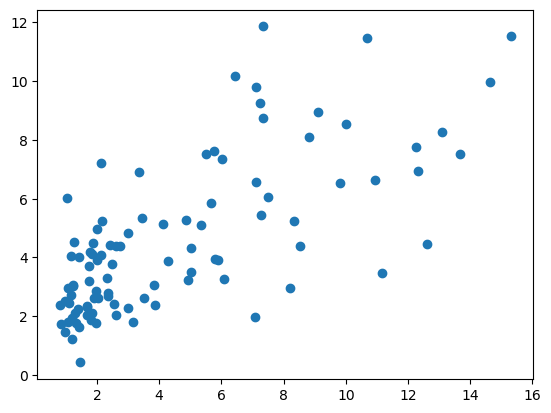

In [26]:
plt.scatter(y_train, clf.predict(x_train))